In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy import ndarray
from typing import Tuple
import json, sys, os, torch, torchvision
import sys
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset

folderpath = '/content/drive/MyDrive/Colab Notebooks/ME592X/Assignment3/DM/'

### Generate a dictionary for folders with four excel files
def input_array1(fName: str):
  data_list = []
  filepath = folderpath + fName + 'C/'
  for file in os.listdir(filepath):
    split_file = file.split('.')
    #init strain rate and temp
    input_strainRate = str(0.) + split_file[1]
    input_strainRate = float(input_strainRate)
    temperature = int(fName)


    fileLocation = filepath + file
    df = pd.read_excel(fileLocation)

    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    df.drop(empty_cols, axis=1, inplace=True)
    try:
      df.columns=['Disp', 'Load', 'EStrain', 'EStress', 'TrueStrain', 'TrueStress1', 'PlasticStrain', 'TrueStress2']
    except ValueError:
      df.columns=['Disp', 'Load', 'EStrain', 'EStress', 'TrueStrain', 'TrueStress1']
    # print(df.head())
    df_data = df.iloc[:,4:6]
    df_update1_data = df_data[df.TrueStress1 != 0]
    df_update2_data = df_update1_data[df.TrueStrain != 0]
    df_update3 = df_update2_data[df.TrueStress1.notna()]
    df_update4 = df_update3[df.TrueStrain.notna()]
    stress_list = df_update4['TrueStress1'].tolist()
    strain_list = df_update4['TrueStrain'].tolist()

    # create list
    temp_list = []
    for j in range(len(strain_list)):
      temp_list.append(float(temperature))
      temp_list.append(input_strainRate)
      temp_list.append(strain_list[j])
      temp_list.append(stress_list[j])
      data_list.append(temp_list)
      temp_list = []
    
    # add zeros at the end for breaking point of material
    temp_list.append(float(temperature))
    temp_list.append(input_strainRate)
    temp_list.append(0.0)
    temp_list.append(0.0)

    data_list.append(temp_list)
    temp_list = []


  return data_list   

# read data from .xls files
temp_50C = input_array1('50')
temp_100C = input_array1('100')
temp_150C = input_array1('150')
temp_200C = input_array1('200')
temp_250C = input_array1('250')
temp_300C = input_array1('300')
temp_350C = input_array1('350')
temp_450C = input_array1('450')
temp_500C = input_array1('500')
temp_550C = input_array1('550')
temp_600C = input_array1('600')
temp_650C = input_array1('650')


# prepare data for lstm
from pandas import DataFrame
from pandas import concat
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 4
  df = DataFrame(data)
  cols, names = list(), list()
  # print(df)
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1): # shift to hist. according to n_in
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out): # shift to future according to n_out
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [ ]:
# lag = 1
temp_50C_supervised_1 = series_to_supervised(temp_50C, 1, 1)
temp_100C_supervised_1 = series_to_supervised(temp_100C, 1, 1)
temp_150C_supervised_1 = series_to_supervised(temp_150C, 1, 1)
temp_200C_supervised_1 = series_to_supervised(temp_200C, 1, 1)
temp_250C_supervised_1 = series_to_supervised(temp_250C, 1, 1)
temp_300C_supervised_1 = series_to_supervised(temp_300C, 1, 1)
temp_350C_supervised_1 = series_to_supervised(temp_350C, 1, 1)
temp_450C_supervised_1 = series_to_supervised(temp_450C, 1, 1)
temp_500C_supervised_1 = series_to_supervised(temp_500C, 1, 1)
temp_550C_supervised_1 = series_to_supervised(temp_550C, 1, 1)
temp_600C_supervised_1 = series_to_supervised(temp_650C, 1, 1)
temp_650C_supervised_1 = series_to_supervised(temp_650C, 1, 1)

In [ ]:
# lag = 3
temp_50C_supervised_3 = series_to_supervised(temp_50C, 3, 1)
temp_100C_supervised_3 = series_to_supervised(temp_100C, 3, 1)
temp_150C_supervised_3 = series_to_supervised(temp_150C, 3, 1)
temp_200C_supervised_3 = series_to_supervised(temp_200C, 3, 1)
temp_250C_supervised_3 = series_to_supervised(temp_250C, 3, 1)
temp_300C_supervised_3 = series_to_supervised(temp_300C, 3, 1)
temp_350C_supervised_3 = series_to_supervised(temp_350C, 3, 1)
temp_450C_supervised_3 = series_to_supervised(temp_450C, 3, 1)
temp_500C_supervised_3 = series_to_supervised(temp_500C, 3, 1)
temp_550C_supervised_3 = series_to_supervised(temp_550C, 3, 1)
temp_600C_supervised_3 = series_to_supervised(temp_650C, 3, 1)
temp_650C_supervised_3 = series_to_supervised(temp_650C, 3, 1)

In [ ]:
# lag = 7
temp_50C_supervised_7 = series_to_supervised(temp_50C, 7, 1)
temp_100C_supervised_7 = series_to_supervised(temp_100C, 7, 1)
temp_150C_supervised_7 = series_to_supervised(temp_150C, 7, 1)
temp_200C_supervised_7 = series_to_supervised(temp_200C, 7, 1)
temp_250C_supervised_7 = series_to_supervised(temp_250C, 7, 1)
temp_300C_supervised_7 = series_to_supervised(temp_300C, 7, 1)
temp_350C_supervised_7 = series_to_supervised(temp_350C, 7, 1)
temp_450C_supervised_7 = series_to_supervised(temp_450C, 7, 1)
temp_500C_supervised_7 = series_to_supervised(temp_500C, 7, 1)
temp_550C_supervised_7 = series_to_supervised(temp_550C, 7, 1)
temp_600C_supervised_7 = series_to_supervised(temp_650C, 7, 1)
temp_650C_supervised_7 = series_to_supervised(temp_650C, 7, 1)

In [ ]:
#### Naive learning and LSTM

import os
import torch
import torch.nn as nn
import torch.nn.functional as F

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      print(f'Reset trainable parameters of layer = {layer}')
      layer.reset_parameters()


class Fully_Connected(nn.Module):
    def __init__(self, in_dims, out_dims):
        super(Fully_Connected, self).__init__()
        
        self.layer_1 = nn.Linear(in_dims, 1024) # fully-connected net
        self.layer_2 = nn.Linear(1024, 512) # fully-connected net
        self.layer_3 = nn.Linear(512, 256) # fully-connected net
        self.layer_4 = nn.Linear(256, out_dims) 

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        return self.layer_4(x)


# # Recurrent neural network (many-to-one)
# # https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py#L39-L58
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc_2 = nn.Linear(128, 32)
        self.fc_3 = nn.Linear(32, num_classes)

    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _  = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = F.relu(self.fc_1(out[:, -1, :]))
        out = F.relu(self.fc_2(out))
        return self.fc_3(out)

class RNN_poll(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, seq_length):
        super(RNN_poll, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_time_stamps = seq_length

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(seq_length*hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 256)
        self.fc_3 = nn.Linear(256, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)

        # shape output to the linear layer (batch_size, seq_length*hidden_dim)
        r_out = r_out.contiguous().view(batch_size,-1)  

        # get final output 
        output = F.relu(self.fc(r_out))
        output = F.relu(self.fc_2(output))
        output = self.fc_3(output)
        return output, hidden



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  268.3332278343939
FOLD 1
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  270.11076207314767
FOLD 2
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  267.6101379394531
FOLD 3
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.72it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  268.6350619408392
FOLD 4
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


epoch avg val loss =  273.26438903808594


<function matplotlib.pyplot.show>

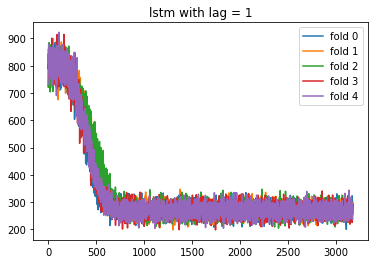

In [ ]:
# LSTM with lag = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 1
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_1.append(temp_100C_supervised_1)
temp_50C_supervised_1.append(temp_150C_supervised_1)
temp_50C_supervised_1.append(temp_250C_supervised_1)
temp_50C_supervised_1.append(temp_300C_supervised_1)
temp_50C_supervised_1.append(temp_350C_supervised_1)
temp_50C_supervised_1.append(temp_450C_supervised_1)
temp_50C_supervised_1.append(temp_550C_supervised_1)
temp_50C_supervised_1.append(temp_600C_supervised_1)
temp_50C_supervised_1.append(temp_650C_supervised_1)
train_set = temp_50C_supervised_1.values

# test set
test_set = temp_200C_supervised_1.append(temp_500C_supervised_1)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)

  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
  network.apply(reset_weights)
  network = network.to(device)

  print('*****')
  print("# of params in model: ", sum(a.numel() for a in network.parameters()))
  print('*****')

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output = network(data)
      
      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./lstm_lag_1_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output = network(data)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('lstm with lag = 1')
plt.savefig('./rnn_lag1_model')
plt.show



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  269.64624909431706
FOLD 1
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.62it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  267.2232641404675
FOLD 2
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.58it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  271.67732927876136
FOLD 3
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  266.40787383048763
FOLD 4
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)
*****
# of params in model:  655709
*****



100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


epoch avg val loss =  272.2081003496724


<function matplotlib.pyplot.show>

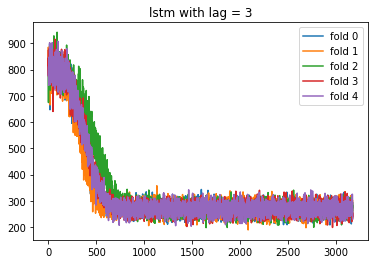

In [ ]:
# LSTM with lag = 3

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 3
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_3.append(temp_100C_supervised_3)
temp_50C_supervised_3.append(temp_150C_supervised_3)
temp_50C_supervised_3.append(temp_250C_supervised_3)
temp_50C_supervised_3.append(temp_300C_supervised_3)
temp_50C_supervised_3.append(temp_350C_supervised_3)
temp_50C_supervised_3.append(temp_450C_supervised_3)
temp_50C_supervised_3.append(temp_550C_supervised_3)
temp_50C_supervised_3.append(temp_600C_supervised_3)
temp_50C_supervised_3.append(temp_650C_supervised_3)
train_set = temp_50C_supervised_3.values

# test set
test_set = temp_200C_supervised_3.append(temp_500C_supervised_3)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)
  # print(len(trainloader))
  # sys.exit()
  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
  network.apply(reset_weights)
  network = network.to(device)

  print('*****')
  print("# of params in model: ", sum(a.numel() for a in network.parameters()))
  print('*****')

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output = network(data)

      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./lstm_lag_3_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output = network(data)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('lstm with lag = 3')
plt.savefig('./lstm_lag3_model')
plt.show



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  266.3085755378969
FOLD 1
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.52it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  271.4768479870212
FOLD 2
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.50it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  270.84287975680445
FOLD 3
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.56it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  267.14359357280114
FOLD 4
--------------------------------
Reset trainable parameters of layer = LSTM(4, 385, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=385, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=1, bias=True)



100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epoch avg val loss =  272.51024701518395


<function matplotlib.pyplot.show>

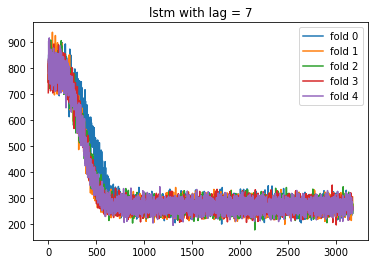

In [ ]:
# LSTM with lag = 7

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 7
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_7.append(temp_100C_supervised_7)
temp_50C_supervised_7.append(temp_150C_supervised_7)
temp_50C_supervised_7.append(temp_250C_supervised_7)
temp_50C_supervised_7.append(temp_300C_supervised_7)
temp_50C_supervised_7.append(temp_350C_supervised_7)
temp_50C_supervised_7.append(temp_450C_supervised_7)
temp_50C_supervised_7.append(temp_550C_supervised_7)
temp_50C_supervised_7.append(temp_600C_supervised_7)
temp_50C_supervised_7.append(temp_650C_supervised_7)
train_set = temp_50C_supervised_7.values

# test set
test_set = temp_200C_supervised_7.append(temp_500C_supervised_7)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)

  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
  network.apply(reset_weights)
  network = network.to(device)

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output = network(data)
      
      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./lstm_lag_7_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output = network(data)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('lstm with lag = 7')
plt.savefig('./lstm_lag7_model')
plt.show



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=4, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  661505
*****


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:07<00:00,  3.43it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have 

Training process has finished. Saving trained model.
Starting testing
epoch avg val loss =  276.81858253479004
FOLD 1
--------------------------------
Reset trainable parameters of layer = Linear(in_features=4, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  661505
*****


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:07<00:00,  3.57it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

  0%|          | 0/25 [00:00<?, ?it/s]

Training process has finished. Saving trained model.
Starting testing
epoch avg val loss =  276.4276566505432
FOLD 2
--------------------------------
Reset trainable parameters of layer = Linear(in_features=4, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  661505
*****



100%|██████████| 25/25 [00:07<00:00,  3.54it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Training process has finished. Saving trained model.
Starting testing
epoch avg val loss =  266.35488653182983
FOLD 3
--------------------------------
Reset trainable parameters of layer = Linear(in_features=4, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  661505
*****



100%|██████████| 25/25 [00:06<00:00,  3.57it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Training process has finished. Saving trained model.
Starting testing
epoch avg val loss =  267.1478500366211
FOLD 4
--------------------------------
Reset trainable parameters of layer = Linear(in_features=4, out_features=1024, bias=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  661505
*****



100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Training process has finished. Saving trained model.
Starting testing
epoch avg val loss =  269.323335647583


<function matplotlib.pyplot.show>

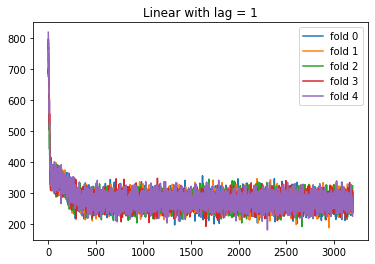

In [ ]:
# linear model with lag = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 1
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_1.append(temp_100C_supervised_1)
temp_50C_supervised_1.append(temp_150C_supervised_1)
temp_50C_supervised_1.append(temp_250C_supervised_1)
temp_50C_supervised_1.append(temp_300C_supervised_1)
temp_50C_supervised_1.append(temp_350C_supervised_1)
temp_50C_supervised_1.append(temp_450C_supervised_1)
temp_50C_supervised_1.append(temp_550C_supervised_1)
temp_50C_supervised_1.append(temp_600C_supervised_1)
temp_50C_supervised_1.append(temp_650C_supervised_1)
train_set = temp_50C_supervised_1.values

# test set
test_set = temp_200C_supervised_1.append(temp_500C_supervised_1)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
# train_X = train_X.reshape((train_X.shape[0], lag, num_features))
# test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler)

  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler)
  
  # Init the neural network
  network = Fully_Connected(in_dims=num_observations, out_dims=1)
  # network = RNN(input_size = num_features, hidden_size=512, num_layers=1, num_classes = 1)
  network.apply(reset_weights)
  network = network.to(device)
  print('*****')
  print("# of params in model: ", sum(a.numel() for a in network.parameters()))
  print('*****')

  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

  
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for i, (data, target) in enumerate(trainloader, 0):

      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = network(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
          
  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')
  
  # Saving the model
  save_path = f'./linear_lag1_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(testloader, 0):

      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      # Generate outputs
      outputs = network(inputs)

      # val loss
      loss = loss_function(outputs, targets)

      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)

x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('Linear with lag = 1')
plt.savefig('./linear_lag1_model')
plt.show


  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  659457
*****


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:08<00:00,  2.85it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  273.6579781809161
FOLD 1
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  659457
*****



100%|██████████| 25/25 [00:08<00:00,  2.92it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  273.84593988233996
FOLD 2
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  659457
*****



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  273.0929284864856
FOLD 3
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  659457
*****



100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  268.2140015632875
FOLD 4
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)
*****
# of params in model:  659457
*****



100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


epoch avg val loss =  266.26277948194934


<function matplotlib.pyplot.show>

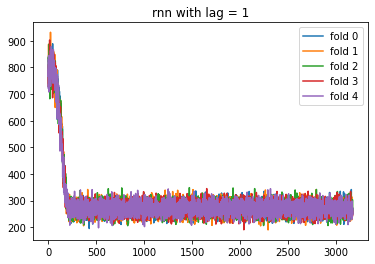

In [ ]:
# RNN with lag = 1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 1
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_1.append(temp_100C_supervised_1)
temp_50C_supervised_1.append(temp_150C_supervised_1)
temp_50C_supervised_1.append(temp_250C_supervised_1)
temp_50C_supervised_1.append(temp_300C_supervised_1)
temp_50C_supervised_1.append(temp_350C_supervised_1)
temp_50C_supervised_1.append(temp_450C_supervised_1)
temp_50C_supervised_1.append(temp_550C_supervised_1)
temp_50C_supervised_1.append(temp_600C_supervised_1)
temp_50C_supervised_1.append(temp_650C_supervised_1)
train_set = temp_50C_supervised_1.values

# test set
test_set = temp_200C_supervised_1.append(temp_500C_supervised_1)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)

  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
  network.apply(reset_weights)
  network = network.to(device)

  print('*****')
  print("# of params in model: ", sum(a.numel() for a in network.parameters()))
  print('*****')

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  hidden = None
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output, hidden = network(data, hidden)

      #memory
      hidden = hidden.data
      batch_size = data.shape[0]
      
      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./rnn_lag_1_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output, _ = network(data, None)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('rnn with lag = 1')
plt.savefig('./rnn_lag1_model')
plt.show



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:09<00:00,  2.72it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  268.7942967568674
FOLD 1
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.74it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  266.29771620227444
FOLD 2
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.72it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  271.1149656234249
FOLD 3
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.76it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  270.7991342852193
FOLD 4
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


epoch avg val loss =  273.127441898469


<function matplotlib.pyplot.show>

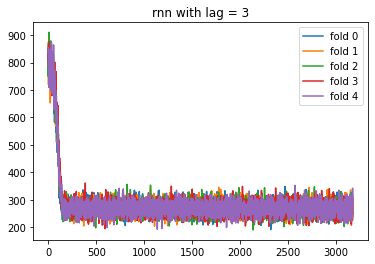

In [ ]:
# RNN with lag = 3

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 3
num_features = 4

# For fold results
results = {}


# train set
temp_50C_supervised_3.append(temp_100C_supervised_3)
temp_50C_supervised_3.append(temp_150C_supervised_3)
temp_50C_supervised_3.append(temp_250C_supervised_3)
temp_50C_supervised_3.append(temp_300C_supervised_3)
temp_50C_supervised_3.append(temp_350C_supervised_3)
temp_50C_supervised_3.append(temp_450C_supervised_3)
temp_50C_supervised_3.append(temp_550C_supervised_3)
temp_50C_supervised_3.append(temp_600C_supervised_3)
temp_50C_supervised_3.append(temp_650C_supervised_3)
train_set = temp_50C_supervised_3.values

# test set
test_set = temp_200C_supervised_3.append(temp_500C_supervised_3)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)

  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
  network.apply(reset_weights)
  network = network.to(device)

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  hidden = None
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output, hidden = network(data, hidden)

      #memory
      hidden = hidden.data
      batch_size = data.shape[0]
      
      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./rnn_lag_3_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output, _ = network(data, None)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('rnn with lag = 3')
plt.savefig('./rnn_lag3_model')
plt.show



  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=3584, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  268.65359890845514
FOLD 1
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=3584, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  270.3399417015814
FOLD 2
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=3584, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  272.82640863233996
FOLD 3
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=3584, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch avg val loss =  270.18655543173514
FOLD 4
--------------------------------
Reset trainable parameters of layer = RNN(4, 512, batch_first=True)
Reset trainable parameters of layer = Linear(in_features=3584, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=1, bias=True)



100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


epoch avg val loss =  264.4716363722278


<function matplotlib.pyplot.show>

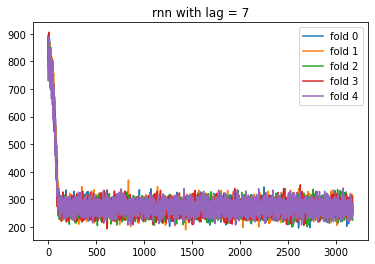

In [ ]:
# RNN with lag = 7

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Configuration options
k_folds = 5
num_epochs = 25
loss_function = nn.L1Loss()
batch_size = 64
lag = 7
num_features = 4

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# train set
temp_50C_supervised_7.append(temp_100C_supervised_7)
temp_50C_supervised_7.append(temp_150C_supervised_7)
temp_50C_supervised_7.append(temp_250C_supervised_7)
temp_50C_supervised_7.append(temp_300C_supervised_7)
temp_50C_supervised_7.append(temp_350C_supervised_7)
temp_50C_supervised_7.append(temp_450C_supervised_7)
temp_50C_supervised_7.append(temp_550C_supervised_7)
temp_50C_supervised_7.append(temp_600C_supervised_7)
temp_50C_supervised_7.append(temp_650C_supervised_7)
train_set = temp_50C_supervised_7.values

# test set
test_set = temp_200C_supervised_7.append(temp_500C_supervised_7)
test_set = test_set.values

# split into x,y's and test/trains
num_observations = lag * num_features
train_X, train_y = train_set[:, :num_observations], train_set[:, -1]
test_X, test_y = test_set[:, :num_observations], test_set[:, -1]

#reshape to [samples, lag, features]
train_X = train_X.reshape((train_X.shape[0], lag, num_features))
test_X = test_X.reshape((test_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(train_X , dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
x_test = torch.tensor(test_X , dtype=torch.float)
y_test = torch.tensor(test_y , dtype=torch.float)

# convert back to torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

dict_losses = {}
dict_losses['fold_0'] = []
dict_losses['fold_1'] = []
dict_losses['fold_2'] = []
dict_losses['fold_3'] = []
dict_losses['fold_4'] = []
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train)):


  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train, 
                    batch_size=batch_size, sampler=train_subsampler, drop_last=True, shuffle=False)
  # print(len(trainloader))
  # sys.exit()
  testloader = torch.utils.data.DataLoader(
                    train,
                    batch_size=batch_size, sampler=test_subsampler, drop_last=True, shuffle=False)
  
  # Init the neural network
  network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
  network.apply(reset_weights)
  network = network.to(device)

  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  hidden = None
  # Run the training loop for defined number of epochs
  for epoch in tqdm(range(0, num_epochs)):

    # Iterate over the DataLoader for training data
    for data, target in trainloader:
      
      # load minibatch
      data = data.to(device)
      target = target.to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      output, hidden = network(data, hidden)

      #memory
      hidden = hidden.data
      batch_size = data.shape[0]
      
      # Compute loss
      loss = loss_function(output, target)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      dict_losses[f'fold_{fold}'].append(loss)
  
  # Saving the model
  save_path = f'./rnn_lag_7_model-fold-{fold}.pth'
  torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  val_loss = 0.0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for data, target in testloader:

      # load minibatch
      data = data.to(device)
      target = target.to(device)


      # Generate outputs
      output, _ = network(data, None)

      # val loss
      loss = loss_function(output, target)


      # Print statistics
      val_loss += loss.item()

    avg_val_loss = val_loss/len(testloader)
    print('epoch avg val loss = ', avg_val_loss)


x_axis = [t for t in range(len(dict_losses['fold_0']))]

plt.plot(x_axis, dict_losses['fold_0'], label='fold 0')
plt.plot(x_axis, dict_losses['fold_1'], label='fold 1')
plt.plot(x_axis, dict_losses['fold_2'], label='fold 2')
plt.plot(x_axis, dict_losses['fold_3'], label='fold 3')
plt.plot(x_axis, dict_losses['fold_4'], label='fold 4')
plt.legend()
plt.title('rnn with lag = 7')
plt.savefig('./rnn_lag7_model')
plt.show


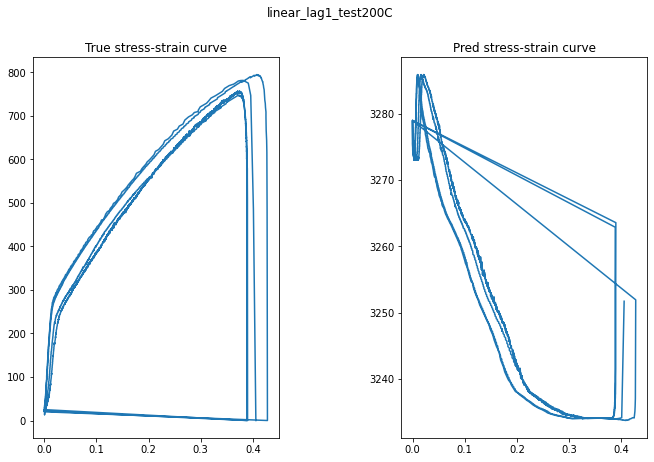

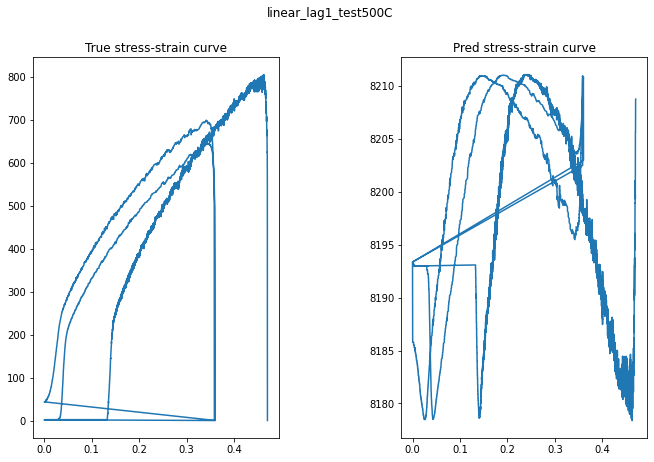

In [ ]:
import sys

# init lag 1 for linear
lag = 1
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_1.values
test_500C_ndarray = temp_500C_supervised_1.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
# test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
# test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = Fully_Connected(in_dims=num_observations, out_dims=1)
network.load_state_dict(torch.load('/content/linear_lag1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
stress_200C = []
strain_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):

      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      # inputs = [temp, strain_rate, strain, stress]
      strain_200C.append(inputs[0, 2])
      stress_200C.append(targets)


      # Generate outputs
      outputs = network(inputs)
      
      #append output to plotting list
      preds_200C.append(outputs)



preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


#plotting
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, (preds_200C))
ax2.set_title('Pred stress-strain curve')

figure.suptitle('linear_lag1_test200C')
plt.show
plt.savefig('linear_lag1_test200C')



#evaluate model on 500C
preds_500C = []
stress_500C = []
strain_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):

      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      # inputs = [temp, strain_rate, strain, stress]
      strain_500C.append(inputs[0, 2])
      stress_500C.append(targets)


      # Generate outputs
      outputs = network(inputs)


      # collect preds
      preds_500C.append(outputs)


#convert to nparray for plotting
preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, (preds_500C))
ax2.set_title('Pred stress-strain curve')
figure.suptitle('linear_lag1_test500C')
plt.show
plt.savefig('linear_lag1_test500C')




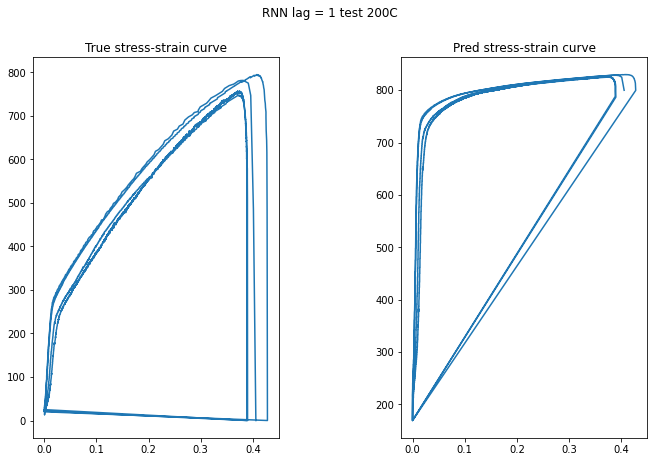

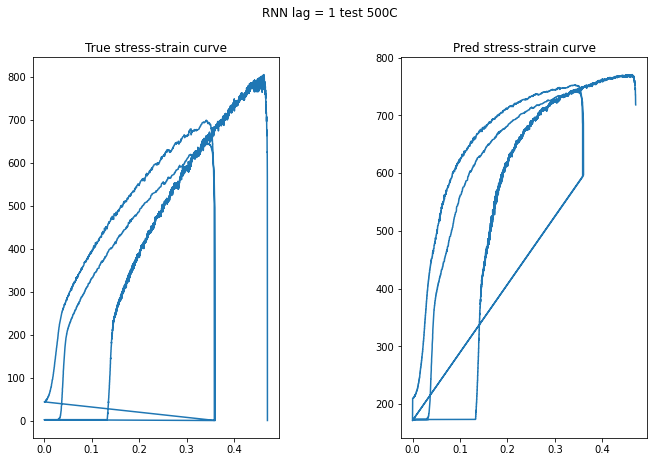

In [ ]:
# init lag 1 for rnn
lag = 1
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_1.values
test_500C_ndarray = temp_500C_supervised_1.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      #input = [temp, strain rate, strain, stress]
      
      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_200C.append(outputs)


preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 1 test 200C')
plt.show
plt.savefig('rnn_lag1_test200C')



#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)


      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_500C.append(outputs)

preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)

figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 1 test 500C')
plt.show
plt.savefig('rnn_lag1_test500C')



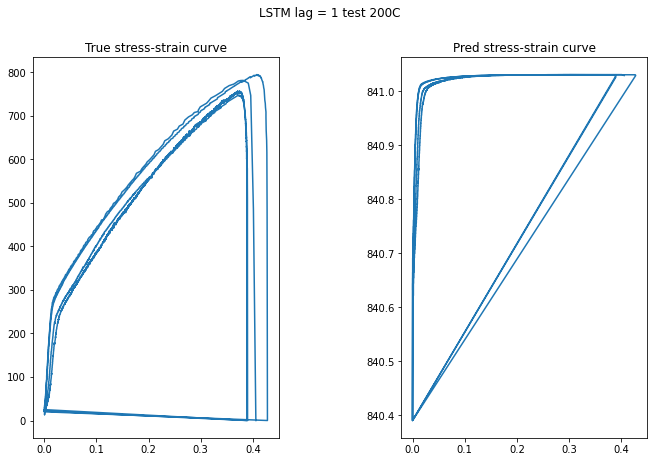

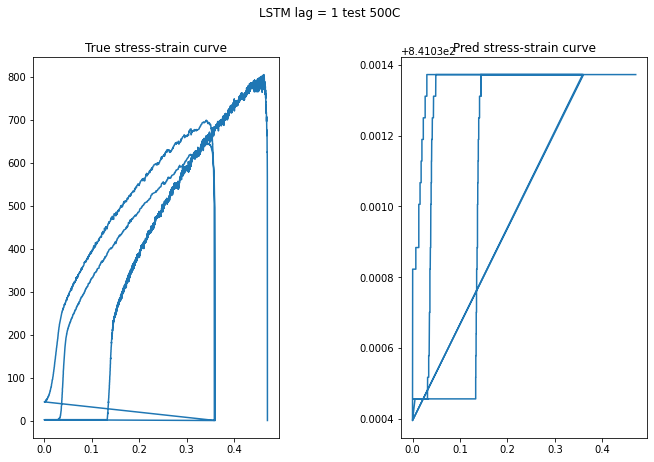

In [ ]:
import sys

# init lag 1 for LSTM
lag = 1
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_1.values
test_500C_ndarray = temp_500C_supervised_1.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_200C.append(outputs)

preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 1 test 200C')
plt.show
plt.savefig('lstm_lag1_test200C')




#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)

      # Generate outputs
      outputs= network(inputs)
      # collect preds
      preds_500C.append(outputs)

preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 1 test 500C')
plt.show
plt.savefig('lstm_lag1_test500C')



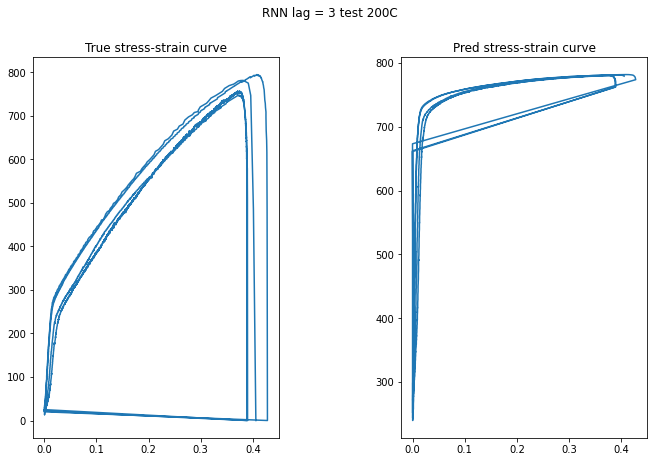

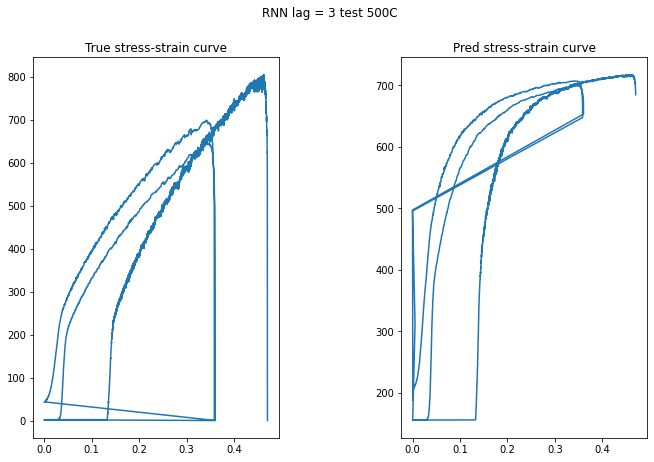

In [ ]:
# init lag 3 for rnn
lag = 3
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_3.values
test_500C_ndarray = temp_500C_supervised_3.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_3_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)


      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_200C.append(outputs)

preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)



figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 3 test 200C')
plt.show
plt.savefig('rnn_lag3_test200C')




#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_500C.append(outputs)


preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 3 test 500C')
plt.show
plt.savefig('rnn_lag3_test500C')



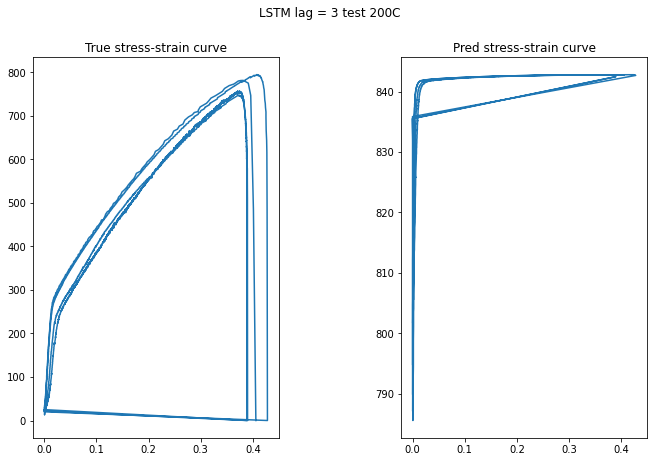

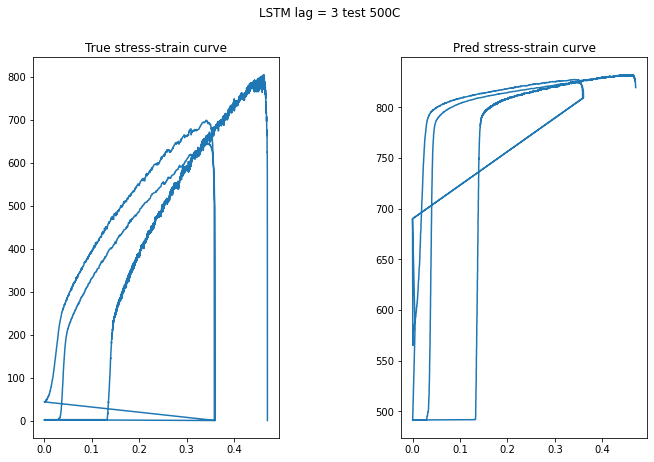

In [ ]:
import sys

# init lag 3 for LSTM
lag = 3
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_3.values
test_500C_ndarray = temp_500C_supervised_3.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_3_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_200C.append(outputs)

preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 3 test 200C')
plt.show
plt.savefig('lstm_lag3_test200C')




#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)

      # Generate outputs
      outputs= network(inputs)
      # collect preds
      preds_500C.append(outputs)

preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 3 test 500C')
plt.show
plt.savefig('lstm_lag3_test500C')



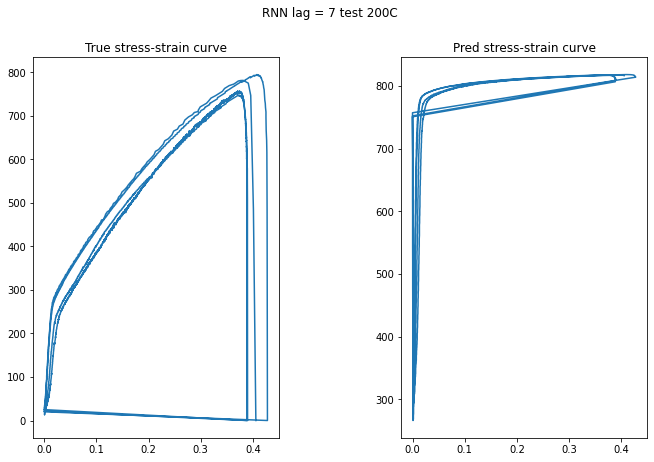

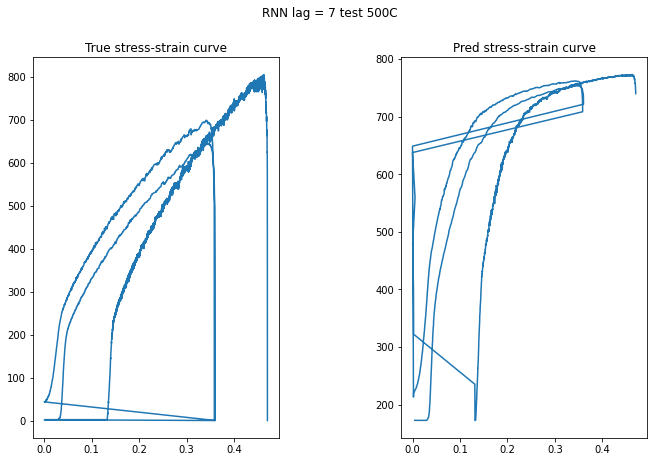

In [ ]:
import sys

# init lag 7 for rnn
lag = 7
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_7.values
test_500C_ndarray = temp_500C_supervised_7.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_7_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_200C.append(outputs)

preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 7 test 200C')
plt.show
plt.savefig('rnn_lag7_test200C')




#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_500C.append(outputs)

preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 7 test 500C')
plt.show
plt.savefig('rnn_lag7_test500C')



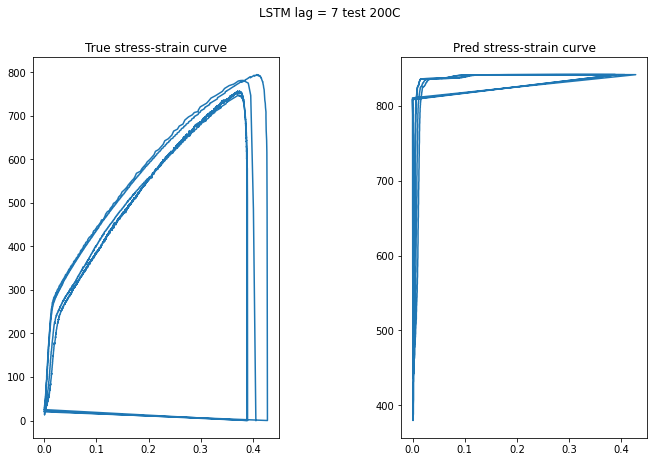

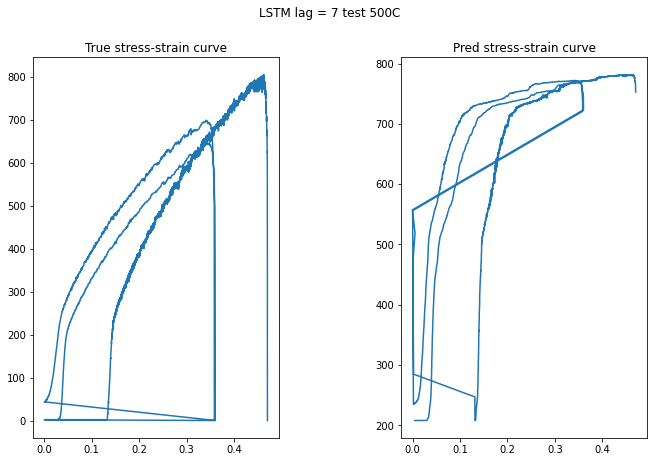

In [ ]:
import sys

# init lag 7 for LSTM
lag = 7
num_features = 4
batch_size = 1

# 
test_200C_ndarray = temp_200C_supervised_7.values
test_500C_ndarray = temp_500C_supervised_7.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_200C_X, test_200C_y = test_200C_ndarray[:, :num_observations], test_200C_ndarray[:, -1]
test_500C_X, test_500C_y = test_500C_ndarray[:, :num_observations], test_500C_ndarray[:, -1]

#reshape to [samples, lag, features]
test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(test_200C_X , dtype=torch.float)
y_train = torch.tensor(test_200C_y, dtype=torch.float)
x_test = torch.tensor(test_500C_X , dtype=torch.float)
y_test = torch.tensor(test_500C_y , dtype=torch.float)

# convert back to torch datasets
test_200C = torch.utils.data.TensorDataset(x_train, y_train)
test_500C = torch.utils.data.TensorDataset(x_test, y_test)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    test_200C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)
loader_500 = torch.utils.data.DataLoader(
                    test_500C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_7_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_200C = []
strain_200C = []
stress_200C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_200C.append(inputs[0, -1, 2])
      stress_200C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_200C.append(outputs)

preds_200C = np.asarray(preds_200C)
stress_200C = np.asarray(stress_200C)
strain_200C = np.asarray(strain_200C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_200C, stress_200C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_200C, preds_200C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 7 test 200C')
plt.show
plt.savefig('lstm_lag7_test200C')




#evaluate model on 500C
preds_500C = []
strain_500C = []
stress_500C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_500, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_500C.append(inputs[0, -1, 2])
      stress_500C.append(targets)

      # Generate outputs
      outputs= network(inputs)
      # collect preds
      preds_500C.append(outputs)

preds_500C = np.asarray(preds_500C)
stress_500C = np.asarray(stress_500C)
strain_500C = np.asarray(strain_500C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_500C, stress_500C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_500C, preds_500C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 7 test 500C')
plt.show
plt.savefig('lstm_lag7_test500C')



**Deployment**

In [ ]:
import sys
import csv
import pandas as pd
# deployment
def strain_(t):
    return (1/6)*(t**3 - 2*t**2 + t)

def strain_rate_(t):
    return (1/6)*(3*t**2 - 4*t + 1)

def stress_(load):
    return load*(1+strain)


def displacement_(q):
  return (q**3 - 2*q**2 + q)

temperature = 400 # in C
sRate = 0.001
disp = []
load = np.linspace(0, 10, 1000)
# print(load)
# sys.exit()
eStrain = []
strain_rate = []
eStress = []
tStrain = []
tStress1 = []
# pStrain = []
# tStress2 = []


################updated strain and strain rate values

for j in range(0, 1000, 1):
  strain = strain_(j)


################


# create strain and strain rate values
strain_linspace = np.linspace(0, 5, 1000)
for g in range(0, len(strain_linspace)):
  timestep = strain_linspace[g]
  m = strain_(timestep)
  n = strain_rate_(timestep)
  eStrain.append(m)
  strain_rate.append(n)


# create displacement values
disp_linspace = np.linspace(0, 5, 1000)
for d in range(0, len(disp_linspace)):
  temp_val = disp_linspace[d]
  dx = displacement_(temp_val)
  disp.append(dx)



# get eStress values
for l in range(0, len(load)):
  temp_Stress = load[l]/6
  eStress.append(temp_Stress)

# get tStrain values
for y in range(0, len(eStrain)):
  val_strain = 1 + eStrain[y]
  temp_trueStrain = np.log(val_strain)
  tStrain.append(temp_trueStrain)


# get tStress values
for u in range(0, len(eStress)):
  val_stress = 1 + eStrain[u]
  temp_trueStress = eStress[u]*(val_stress)
  tStress1.append(temp_trueStress)

#generate dataframe for excel file
df = pd.DataFrame({'Disp': disp, 'Load': load, 'Estrain': eStrain, 'EStress': eStress,'StrainRate': strain_rate ,'Tstrain': tStrain, 'Tstress1': tStress1})


# # save dataframe to excel file
filename = str(temperature) + '.xlsx'

# # print(filename)
df.to_excel(filename, index=False)

# print('df')
print(df)







          Disp      Load    Estrain   EStress  StrainRate   Tstrain   Tstress1
0     0.000000   0.00000   0.000000  0.000000    0.166667  0.000000   0.000000
1     0.004955   0.01001   0.000826  0.001668    0.163343  0.000825   0.001670
2     0.009811   0.02002   0.001635  0.003337    0.160043  0.001634   0.003342
3     0.014567   0.03003   0.002428  0.005005    0.156769  0.002425   0.005017
4     0.019226   0.04004   0.003204  0.006673    0.153520  0.003199   0.006695
..         ...       ...        ...       ...         ...       ...        ...
995  78.884081   9.95996  13.147347  1.659993    9.246780  2.649527  23.484501
996  79.162087   9.96997  13.193681  1.661662    9.268381  2.652797  23.585096
997  79.440741   9.97998  13.240124  1.663330    9.290007  2.656064  23.686025
998  79.720045   9.98999  13.286674  1.664998    9.311658  2.659327  23.787289
999  80.000000  10.00000  13.333333  1.666667    9.333333  2.662588  23.888889

[1000 rows x 7 columns]


In [ ]:
import numpy as np
import sys
from numpy import ndarray
from typing import Tuple
import json, sys, os, torch, torchvision
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import KFold

deploy_filepath = '/content/drive/MyDrive/Colab Notebooks/ME592X/Assignment3/Deployment/'

def deploy_input_array(fName: str):
  data_list = []
  filepath = deploy_filepath + fName + 'C/'
  for file in os.listdir(filepath):
    temperature = int(fName)


    fileLocation = filepath + file
    df = pd.read_excel(fileLocation)

    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    df.drop(empty_cols, axis=1, inplace=True)
    df = pd.DataFrame({'Disp': disp, 'Load': load, 'Estrain': eStrain, 'EStress': eStress,'StrainRate': strain_rate ,'Tstrain': tStrain, 'Tstress1': tStress1})

    df_data = df.iloc[:,4:7]

    df_update1_data = df_data[df.Tstrain != 0]
    df_update2_data = df_update1_data[df.Tstress1 != 0]
    df_update3_data = df_update2_data[df.StrainRate !=0]
    df_update4 = df_update3_data[df.Tstrain.notna()]
    df_update5 = df_update4[df.Tstress1.notna()]
    df_update6 = df_update5[df.StrainRate.notna()]

    stress_list = df_update6['Tstress1'].tolist()
    strain_rate_list = df_update6['StrainRate'].tolist()
    stress_list = df_update6['Tstress1'].tolist()
    strain_list = df_update4['Tstrain'].tolist()


    # create list
    temp_list = []
    for j in range(len(strain_list)):
      temp_list.append(float(temperature))
      temp_list.append(strain_rate_list[j])
      temp_list.append(strain_list[j])
      temp_list.append(stress_list[j])
      data_list.append(temp_list)
      temp_list = []
    
    # add zeros at the end for breaking point of material
    temp_list.append(float(temperature))
    temp_list.append(0.0)
    temp_list.append(0.0)
    # temp_list.append(0.0)

    data_list.append(temp_list)
    temp_list = []


  return data_list   
  
# read data from .xls files

deploy_temp_400C = deploy_input_array('400')
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 4
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1): # shift to hist. according to n_in
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out): # shift to future according to n_out
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together

  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg


#prepare data for lstm

# lag = 1
deploy_temp_400C_supervised_1 = series_to_supervised(deploy_temp_400C, 1, 1)

# lag = 3
deploy_temp_400C_supervised_3 = series_to_supervised(deploy_temp_400C, 3, 1)

# lag = 7
deploy_temp_400C_supervised_7 = series_to_supervised(deploy_temp_400C, 7, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


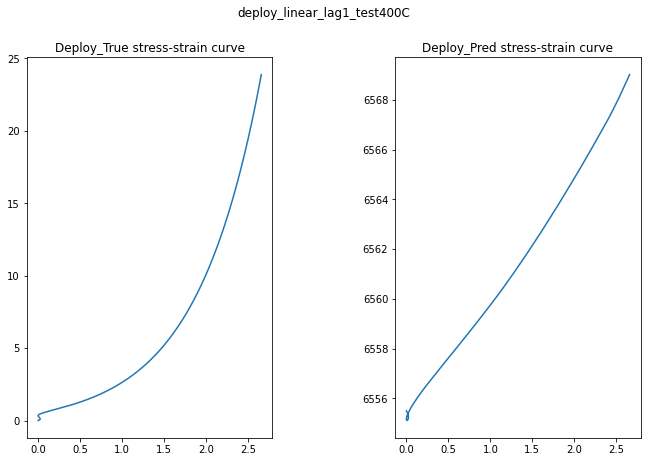

In [ ]:
## predicting for generated data using Linear Network

# lag 1

import sys

# init lag 1 for linear
lag = 1
num_features = 4
batch_size = 1

deploy_temp_400C_ndarray = deploy_temp_400C_supervised_1.values

# split into x,y's and test/trains
num_observations = lag * num_features
test_400C_X_deploy, test_400C_y_deploy = deploy_temp_400C_ndarray[:, :num_observations], deploy_temp_400C_ndarray[:, -1]

#reshape to [samples, lag, features]
# test_200C_X = test_200C_X.reshape((test_200C_X.shape[0], lag, num_features))
# test_500C_X = test_500C_X.reshape((test_500C_X.shape[0], lag, num_features))

# convert to tensor

x_test = torch.tensor(test_400C_X_deploy , dtype=torch.float)
y_test = torch.tensor(test_400C_y_deploy , dtype=torch.float)

# convert back to torch datasets

test_400C_deploy = torch.utils.data.TensorDataset(x_test, y_test)

# loaders


loader_400 = torch.utils.data.DataLoader(
                    test_400C_deploy, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = Fully_Connected(in_dims=num_observations, out_dims=1)
network.load_state_dict(torch.load('/content/linear_lag1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 400C
preds_400C = []
stress_400C = []
strain_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_400, 0):

      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)
      
      strain_400C.append(inputs[0, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs = network(inputs)
    
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('Deploy_True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Deploy_Pred stress-strain curve')

figure.suptitle('deploy_linear_lag1_test400C')
plt.show
plt.savefig('deploy_linear_lag1_test400C')







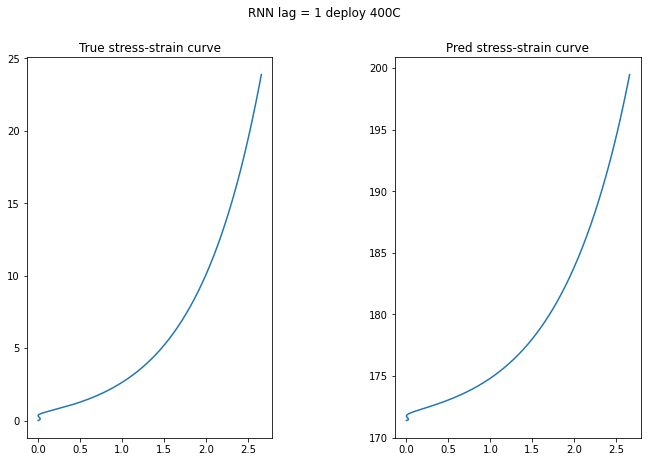

In [ ]:
## Call LSTM network
# deployment init lag 1 for rnn
lag = 1
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_1.values
# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 1 deploy 400C')
plt.show
plt.savefig('rnn_lag1_deploy400C')


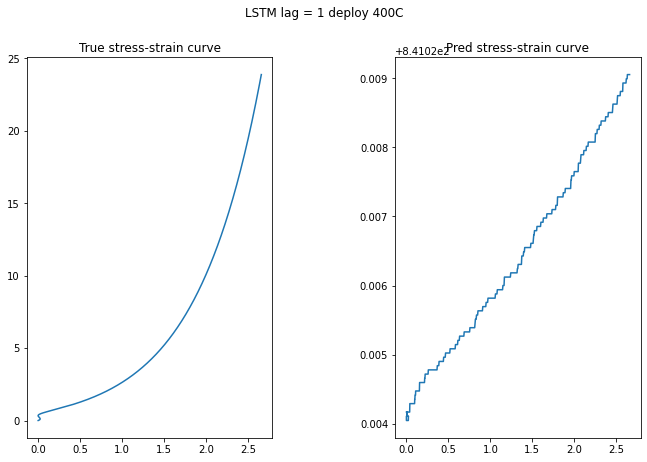

In [ ]:
## Call LSTM network
# deployment init lag 1 for LSTM
lag = 1
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_1.values

# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_1_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 1 deploy 400C')
plt.show
plt.savefig('lstm_lag1_deploy400C')




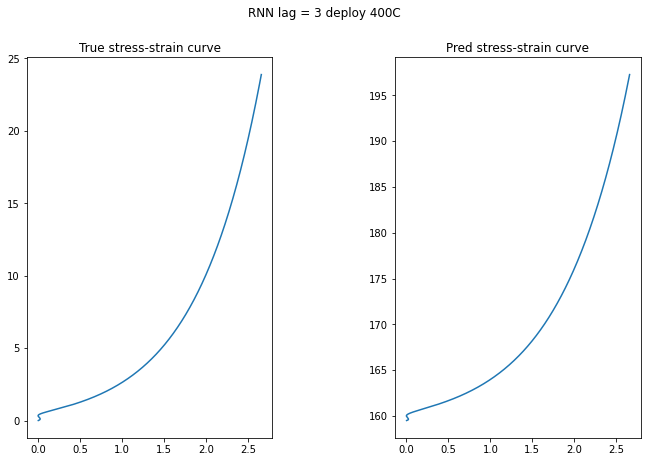

In [ ]:
## Call LSTM network
# deployment init lag 3 for rnn
lag = 3
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_3.values

# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_3_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 3 deploy 400C')
plt.show
plt.savefig('rnn_lag3_deploy400C')





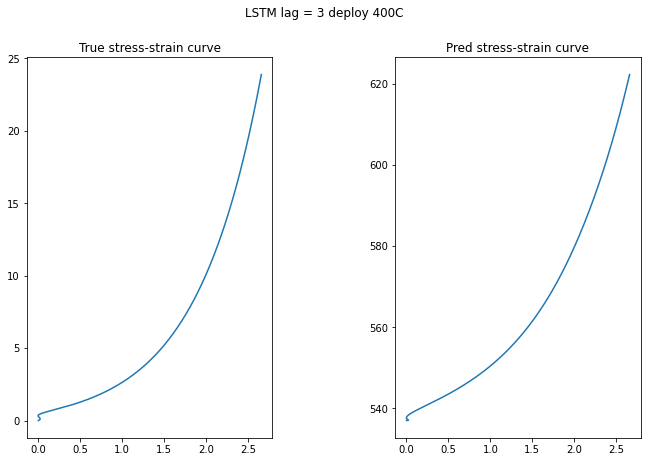

In [ ]:
## Call LSTM network
# deployment init lag 3 for LSTM
lag = 3
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_3.values

# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)
# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_3_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 3 deploy 400C')
plt.show
plt.savefig('lstm_lag3_deploy400C')




tensor([[-1.9192]], device='cuda:0')


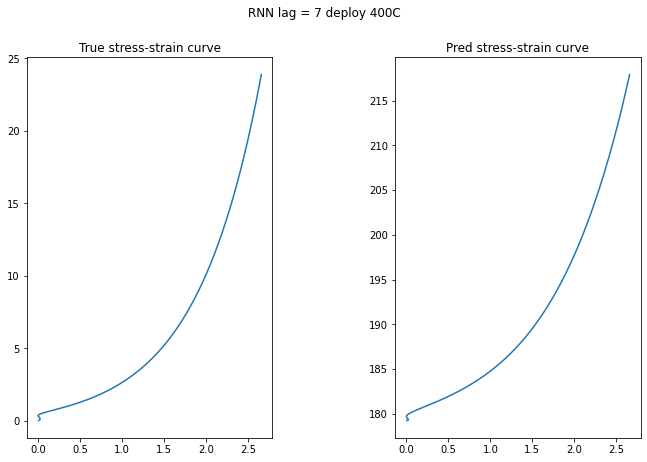

In [ ]:
## Call LSTM network
# deployment init lag 3 for rnn
lag = 7
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_7.values

# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN_poll(input_size=num_features, output_size=1, hidden_dim=512, n_layers=1, seq_length=lag)
network.load_state_dict(torch.load('/content/rnn_lag_7_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)


      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs, _ = network(inputs, None)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('RNN lag = 7 deploy 400C')
plt.show
plt.savefig('rnn_lag7_deploy400C')


print(sum(preds_400C - (stress_400C + 185))/len(preds_400C))


<function matplotlib.pyplot.show>

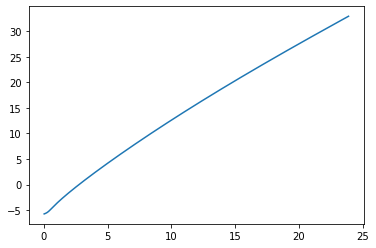

In [ ]:
plt.plot(stress_400C, (preds_400C-185))
plt.show

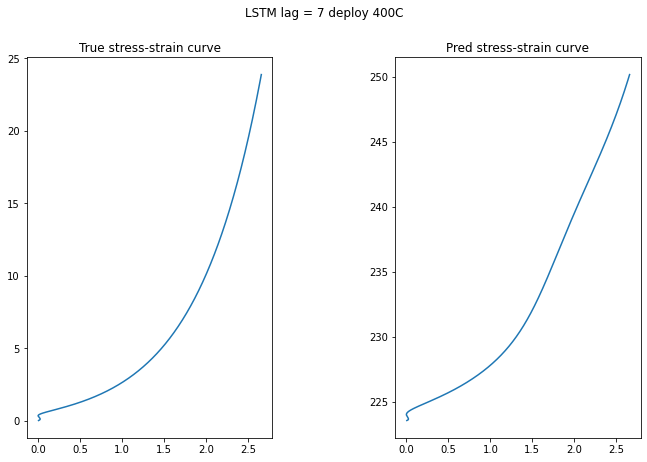

In [ ]:
## Call LSTM network
# deployment init lag 7 for LSTM
lag = 7
num_features = 4
batch_size = 1

# 
deploy_400C_ndarray = deploy_temp_400C_supervised_7.values

# split into x,y's and test/trains
num_observations = lag * num_features
deploy_400C_X, deploy_400C_y = deploy_400C_ndarray[:, :num_observations], deploy_400C_ndarray[:, -1]

#reshape to [samples, lag, features]

deploy_400C_X = deploy_400C_X.reshape((deploy_400C_X.shape[0], lag, num_features))

# convert to tensor
x_train = torch.tensor(deploy_400C_X , dtype=torch.float)
y_train = torch.tensor(deploy_400C_y, dtype=torch.float)

# convert back to torch datasets

deploy_400C = torch.utils.data.TensorDataset(x_train, y_train)

# loaders
loader_200 = torch.utils.data.DataLoader(
                    deploy_400C, 
                    batch_size=batch_size, drop_last=False, shuffle=False)

# load model
network = RNN(input_size = num_features, hidden_size=385, num_layers=1, num_classes = 1)
network.load_state_dict(torch.load('/content/lstm_lag_7_model-fold-0.pth'))
network.eval()
network.to(device)

#evaluate model on 200C
preds_400C = []
strain_400C = []
stress_400C = []
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data, target) in enumerate(loader_200, 0):
      # load minibatch
      inputs = data.to(device)
      targets = target.to(device)

      strain_400C.append(inputs[0, -1, 2])
      stress_400C.append(targets)

      # Generate outputs
      outputs = network(inputs)
      # collect preds
      preds_400C.append(outputs)

preds_400C = np.asarray(preds_400C)
stress_400C = np.asarray(stress_400C)
strain_400C = np.asarray(strain_400C)


figure, (ax1, ax2) = plt.subplots(1,2, figsize = (11, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(grid[0,0])
ax1.plot(strain_400C, stress_400C)
ax1.set_title('True stress-strain curve')

ax2 = plt.subplot(grid[0,1])
ax2.plot(strain_400C, preds_400C)
ax2.set_title('Pred stress-strain curve')
figure.suptitle('LSTM lag = 7 deploy 400C')
plt.show
plt.savefig('lstm_lag7_deploy400C')



